In [ ]:
# Install duckdb
!pip install duckdb --quiet
import duckdb
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Mounted at /content/drive


In [ ]:
# Add a shortcut to MIMIC-III dir to your drive (https://drive.google.com/drive/folders/11HfvZC7kx4ha5syrMLXJHkKF_5pL1b0S?usp=sharing)
drive_path = '/content/drive/MyDrive/' # MIMIC-III shortcut path in your drive (change accordingly)
con = duckdb.connect(f'{drive_path}/mimiciii.duckdb')

In [ ]:

LABQUERY = \
f"""--sql
SELECT labevents.subject_id::INTEGER AS subject_id\
      , labevents.hadm_id::INTEGER AS hadm_id\
      , labevents.charttime::TIMESTAMP AS charttime
      , labevents.itemid::INTEGER AS itemid\
      , labevents.valuenum::DOUBLE AS valuenum
      , admissions.admittime::TIMESTAMP AS admittime
FROM labevents
          INNER JOIN admissions
                    ON labevents.subject_id = admissions.subject_id
                        AND labevents.hadm_id = admissions.hadm_id
                        AND labevents.charttime::TIMESTAMP between
                            (admissions.admittime::TIMESTAMP)
                            AND (admissions.admittime::TIMESTAMP + interval 48 hour)
                        AND itemid::INTEGER IN ? \
                        """

VITQUERY = f"""--sql
        SELECT chartevents.subject_id::INTEGER AS subject_id\
             , chartevents.hadm_id::INTEGER AS hadm_id\
             , chartevents.charttime::TIMESTAMP AS charttime\
             , chartevents.itemid::INTEGER AS itemid\
             , chartevents.valuenum::DOUBLE AS valuenum\
             , admissions.admittime::TIMESTAMP AS admittime\
        FROM chartevents
                 INNER JOIN admissions
                            ON chartevents.subject_id = admissions.subject_id
                                AND chartevents.hadm_id = admissions.hadm_id
                                AND chartevents.charttime::TIMESTAMP between
                                   (admissions.admittime::TIMESTAMP)
                                   AND (admissions.admittime::TIMESTAMP + interval 48 hour)
                                AND itemid::INTEGER in ?
      -- exclude rows marked as error
      AND chartevents.error::INTEGER IS DISTINCT \
        FROM 1 \
        """

In [ ]:
# Load the filtered patients file
df = pd.read_parquet("1-3-3-min_54h_first_admissions_filtered_age_path.parquet")
assert len(df) == len(df['subject_id'].unique())
print('Num patients:', len(df))

Num patients: 22927


In [ ]:
# Load labels
mortality = pd.read_parquet('1-2-1-mortality.parquet')
prolonged_stay = pd.read_parquet('1-2-2-prolonged-stay.parquet')
readmission = pd.read_parquet('1-2-3-readmission.parquet')

In [ ]:
demographics = pd.read_parquet('1-4-1a-demographics.parquet').drop(columns=['eth_raw'])
demographics = demographics.rename(columns={'eth_broad': 'ethnicity'})

# Coarse-grained categories for data analysis

demographics.ethnicity = demographics.ethnicity
demographics.loc[(demographics.ethnicity.str.contains('^white')),'ethnicity'] = 'white'
demographics.loc[(demographics.ethnicity.str.contains('^black')),'ethnicity'] = 'black'
demographics.loc[(demographics.ethnicity.str.contains('^hisp')) | (demographics.ethnicity.str.contains('^latin')),'ethnicity'] = 'hispanic'
demographics.loc[(demographics.ethnicity.str.contains('^asia')),'ethnicity'] = 'asian'
demographics.loc[~(demographics.ethnicity.str.contains('|'.join(['white', 'black', 'hispanic', 'asian']))),'ethnicity'] = 'other'

In [ ]:
df = pd.merge(df, mortality[['subject_id', 'admission_id', 'mortality']], on=['subject_id', 'admission_id'], how='left')
df = pd.merge(df, prolonged_stay[['subject_id', 'admission_id', 'prolonged_stay']], on=['subject_id', 'admission_id'], how='left')
df = pd.merge(df, readmission[['subject_id', 'readmission']], on=['subject_id'], how='left')
display(df.head())

,subject_id,admission_id,admittime,dischtime,mortality,prolonged_stay,readmission
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,False,True,False
1,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,False,True,False
2,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,True,False,False
3,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,False,True,False
4,12,112213,2104-08-07 10:15:00,2104-08-20 02:57:00,True,True,False


In [ ]:
for col in ['mortality', 'prolonged_stay', 'readmission']:
    print(f"Value counts for '{col}':")
    print(df[col].value_counts())
    positive_ratio = df[col].value_counts(normalize=True)[True] * 100
    print(f"Positive class percentage for '{col}': {positive_ratio}\n")

Value counts for 'mortality':
mortality
False    20117
True      2810
Name: count, dtype: Int64
Positive class ratio for 'mortality': 12.256291708466001

Value counts for 'prolonged_stay':
prolonged_stay
True     12573
False    10354
Name: count, dtype: Int64
Positive class ratio for 'prolonged_stay': 54.83927247350285

Value counts for 'readmission':
readmission
False    21814
True      1113
Name: count, dtype: Int64
Positive class ratio for 'readmission': 4.85453831726785



In [ ]:
lavbevent_meatdata = pd.read_csv('labs_metadata.csv') # metadata from homework
vital_meatdata = pd.read_csv('vital_metadata.csv') # metadata from homework

In [ ]:
# icu =  con.execute(ICUQ, [subject_ids]).fetchdf().rename(str.lower, axis='columns')
lab = con.execute(LABQUERY, [lavbevent_meatdata['itemid'].tolist()]).fetchdf().rename(str.lower, axis='columns')
vit = con.execute(VITQUERY, [vital_meatdata['itemid'].tolist()]).fetchdf().rename(str.lower, axis='columns')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
#Filter Invalid Mesurments
labs = lab[lab['hadm_id'].isin(df['admission_id'])]
labs = pd.merge(labs,lavbevent_meatdata,on='itemid')
labs = labs[labs['valuenum'].between(labs['min'],labs['max'],  inclusive='both')]
labs = labs.drop(columns=['min','max'])

vit = vit[vit['hadm_id'].isin(df['admission_id'])]
vit = vit.merge(vital_meatdata, on='itemid', how='left')
vit = vit[(vit['valuenum'] >= vit['min']) & (vit['valuenum'] <= vit['max'])]
vit = vit.drop(columns=['min', 'max'])

In [ ]:
# Units Conversion
vit.loc[(vit['feature name'] == 'TempF'),'valuenum'] = (vit[vit['feature name'] == 'TempF']['valuenum']-32)/1.8
vit.loc[vit['feature name'] == 'TempF','feature name'] = 'TempC'

In [ ]:
vit_mean = vit.pivot_table(
    index=['subject_id', 'hadm_id'],
    columns='feature name',
    values='valuenum',
    aggfunc=['mean']
).reset_index()

vit_mean.columns = [f"{feat}_{stat}" for stat, feat in vit_mean.columns]
vit_mean = vit_mean.rename(columns={'_hadm_id': 'hadm_id',
                              '_subject_id': 'subject_id'})

In [ ]:
labs_mean = labs.pivot_table(
    index=['subject_id', 'hadm_id'],
    columns='feature name',
    values='valuenum',
    aggfunc=['mean']
).reset_index()

labs_mean.columns = [f"{feat}_{stat}" for stat, feat in labs_mean.columns]
labs_mean = labs_mean.rename(columns={'_hadm_id': 'hadm_id',
                              '_subject_id': 'subject_id'})

In [ ]:
labs_mean = labs_mean.rename(columns={'hadm_id': 'admission_id'})
vit_mean = vit_mean.rename(columns={'hadm_id': 'admission_id'})

In [ ]:
# Merge
merged = df.merge(labs_mean, on=['subject_id', 'admission_id'], how='left')
merged = merged.drop(columns=['admittime', 'dischtime'])
merged = merged.merge(vit_mean, on=['subject_id', 'admission_id'], how='left')
merged = merged.merge(demographics, on=['subject_id', 'admission_id'], how='left')

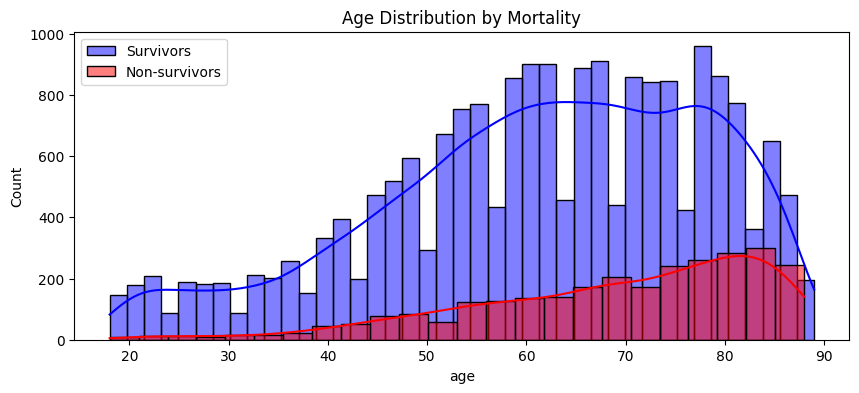

Survivors normality: The data is not normally distributed.
Non-survivors: The data is not normally distributed.


In [ ]:
#@ Verify that age is not normally distributed

from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

# Test for mortality (we assume similar behavior for other tasks)
survivors = merged[merged['mortality'] == False]['age']
non_survivors = merged[merged['mortality'] == True]['age']

# How the ditribution looks like
plt.figure(figsize=(10, 4))
sns.histplot(survivors, color='blue', label='Survivors', kde=True)
sns.histplot(non_survivors, color='red', label='Non-survivors', kde=True)
plt.legend()
plt.title("Age Distribution by Mortality")
plt.show()

def is_normally_distributed(val, alpha=0.05):
  if val < alpha:
    return "The data is not normally distributed."
  else:
    return "The data is normally distributed."

# Shapiro-Wilk normality test
print("Survivors normality:", is_normally_distributed(shapiro(survivors.sample(500))[1]))
print("Non-survivors:", is_normally_distributed(shapiro(non_survivors.sample(500))[1]))

In [ ]:
#@title Cont. Feaures
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def compare_groups_cont(df, group_col, features):

  group1_df = df[df[group_col] == False]
  group2_df = df[df[group_col] == True]

  results = []

  for feature in features:
    group1 = group1_df[feature].dropna()
    group2 = group2_df[feature].dropna()

    # Mann-Whitney U test
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')

    results.append({
        'feature': feature,
        'u_statistic': stat,
        'p_value': p,
        'median_group_1_false': group1.median(),
        'median_group_2_true': group2.median()
    })

  results_df = pd.DataFrame(results)
  results_df = results_df.sort_values(by='p_value')

  p_values = results_df['p_value'].values
  corrected = multipletests(p_values, method='bonferroni')
  results_df['p_adj'] = corrected[1]  # adjusted p-values
  results_df['significant'] = corrected[0]  # True/False for significance

  print(results_df)

In [ ]:

lab_features = lavbevent_meatdata['feature name'].unique()
vit_features = vital_meatdata['feature name'].unique()

lab_features_cols = [col for col in merged.columns if any(feature in col for feature in lab_features)]
vit_features_cols = [col for col in merged.columns if any(feature in col for feature in vit_features)]

cont_features_cols = lab_features_cols + vit_features_cols
cont_features_cols.append('age')

['ALBUMIN_mean', 'ANION GAP_mean', 'BICARBONATE_mean', 'BILIRUBIN_mean', 'BUN_mean', 'CHLORIDE_mean', 'CREATININE_mean', 'GLUCOSE_mean', 'HEMATOCRIT_mean', 'HEMOGLOBIN_mean', 'INR_mean', 'LACTATE_mean', 'MAGNESIUM_mean', 'PHOSPHATE_mean', 'PLATELET_mean', 'POTASSIUM_mean', 'PT_mean', 'PTT_mean', 'SODIUM_mean', 'WBC_mean', 'DiasBP_mean', 'Glucose_mean', 'HeartRate_mean', 'MeanBP_mean', 'RespRate_mean', 'SpO2_mean', 'SysBP_mean', 'TempC_mean', 'age']


In [ ]:
for prediction_target in ['mortality', 'prolonged_stay', 'readmission']:
  print('**'*30)
  print('Prediction Target:', prediction_target)
  print('**'*30)
  compare_groups_cont(merged, prediction_target, cont_features_cols)

************************************************************
Prediction Target: mortality
************************************************************
             feature  u_statistic        p_value  median_group_1_false  \
4           BUN_mean   17752610.5  4.265174e-200             16.500000   
1     ANION GAP_mean   19433066.5  3.081404e-130             13.000000   
28               age   20484039.5  6.043242e-124             63.000000   
10          INR_mean   15958604.0   2.493278e-92              1.200000   
24     RespRate_mean   13242311.0   1.841036e-89             17.953463   
0       ALBUMIN_mean    7470885.0   7.800209e-88              3.300000   
16           PT_mean   16145476.0   3.625781e-84             13.800000   
6    CREATININE_mean   22073559.5   9.712352e-63              0.900000   
2   BICARBONATE_mean   32316792.5   5.275840e-56             24.666667   
9    HEMOGLOBIN_mean   31481368.5   2.363499e-37             10.909167   
11      LACTATE_mean    5410512.5  

In [ ]:
#@title Categorical Features

from scipy.stats import chi2_contingency

def compare_groups_categorical(df, group_col, categorical_features):
  results = []
  for feature in categorical_features:
      contingency_table = pd.crosstab(df[feature], df[group_col])

      # Run Chi-square test
      chi2, p, dof, expected = chi2_contingency(contingency_table)

      # Verify assumptions: not too many low counts
      low_count_cells = (expected < 5).sum()
      total_cells = expected.size
      percent_low = (low_count_cells / total_cells) * 100

      results.append({
          'feature': feature,
          'chi2_statistic': chi2,
          'degrees_of_freedom': dof,
          'p_value': p,
          'percent_low_expected_counts': percent_low
      })

      print(f"Feature: {feature}")
      print("Contingency Table:")
      print(contingency_table, "\n")
      print("Expected Counts:")
      print(pd.DataFrame(expected,
                        index=contingency_table.index,
                        columns=contingency_table.columns))
      print(f"\nChi-square statistic = {chi2:.4f}, p-value = {p:.4e}, dof = {dof}")
      print(f"Percent of cells with expected counts < 5: {percent_low:.2f}%")
      if percent_low > 20:
          print("Warning: More than 20% of cells have low expected counts. Consider combining categories.\n")
      print("-" * 60)

  results_df = pd.DataFrame(results).sort_values(by='p_value')
  print("\nSummary of Chi-square tests:")
  print(results_df)

In [ ]:
categorical_features = ['gender', 'ethnicity', 'insurance', 'admission_type']

for prediction_target in ['mortality', 'prolonged_stay', 'readmission']:
  print('**'*30)
  print('Prediction Target:', prediction_target)
  print('**'*30)
  compare_groups_categorical(merged, prediction_target, categorical_features)

************************************************************
Prediction Target: mortality
************************************************************
Feature: gender
Contingency Table:
mortality  False  True 
gender                 
F           8376   1240
M          11741   1570 

Expected Counts:
mortality         False        True 
gender                              
F           8437.434989  1178.565011
M          11679.565011  1631.434989

Chi-square statistic = 6.1844, p-value = 1.2888e-02, dof = 1
Percent of cells with expected counts < 5: 0.00%
------------------------------------------------------------
Feature: ethnicity
Contingency Table:
mortality  False  True 
ethnicity              
other      20117   2810 

Expected Counts:
mortality    False   True 
ethnicity                 
other      20117.0  2810.0

Chi-square statistic = 0.0000, p-value = 1.0000e+00, dof = 0
Percent of cells with expected counts < 5: 0.00%
----------------------------------------------------------